In [1]:
import sys, os
import pandas as pd
import polars as pl
import numpy as np
from dotenv import load_dotenv

sys.path.append('/Users/katringrunert/Projects/Uni/thesis/neuro-symbolic-demand-forecasting')
# when running on JupyterHub the dot-env-path needs to be adapted
load_dotenv("../.env")

datetime_format = "%Y-%m-%d %H:%M%z"

In [108]:
%load_ext autoreload

In [109]:
%autoreload

In [ ]:
from src.neuro_symbolic_demand_forecasting.database.snowflake import SnowflakeDao


sf_dao = SnowflakeDao(
    url=os.getenv("SNOWFLAKE_URL"),
    uid=os.getenv("SNOWFLAKE_UID"),
    pwd=os.getenv("SNOWFLAKE_PASSWORD"),
    database=os.getenv("SNOWFLAKE_DATABASE"),
    schema=os.getenv("SNOWFLAKE_SCHEMA"),
)

sf_dao.connect()

In [ ]:
contract_df = sf_dao.fetch_list("SELECT * FROM SANDBOX.KATRIN.CONTRACT_DATA")
contract_df

In [ ]:
from src.neuro_symbolic_demand_forecasting.helpers.constants import P4_TS_SUMMER

start, end = "2023-05-01 00:00+02:00", "2023-05-16 00:00+02:00"
columns = "EAN_SHA256, LDN, ODN, READINGDATE, LDN_DIFF, ODN_DIFF"
df = sf_dao.fetch_list(f"SELECT {columns} FROM {P4_TS_SUMMER} WHERE READINGDATE>='{start}' AND READINGDATE<='{end}';")
data = df 
data.head()

# data.write_csv("./p4_data_extract.csv")


In [ ]:
data = pl.read_csv("./p4_data_extract.csv", try_parse_dates=True)
data

In [ ]:
data = data.filter(pl.col('readingdate').dt.minute() == 0)

## Checking and filtering for missing data

In [ ]:
for k, g in data.group_by(['ean_sha256']):
    print(g[0:20])
    break

In [ ]:
min_length = (data['readingdate'].max() - data['readingdate'].min()).days * 24 

missing_points = pl.DataFrame()
for key, group  in data.group_by(['ean_sha256']):
    if len(group) < min_length:
        missing_points = pl.concat([missing_points, group])

missing_points

In [ ]:
missing_points['ean_sha256'].unique()

In [ ]:
df_for_train = data.filter(~pl.col('ean_sha256').is_in(missing_points['ean_sha256'].unique()))
# df_for_train = df_for_train.filter(pl.col('readingdate').dt.minute() == 0)
data, df_for_train

In [ ]:
data = df_for_train

## Dividing data into PV and non-PV cluster

In [ ]:
data = data.with_columns(pl.col('odn_diff').cast(pl.Float64), pl.col('ldn_diff').cast(pl.Float64))

In [ ]:
grouped = data.group_by('ean_sha256').agg(pl.sum('odn_diff').alias('odn_sum'))


In [ ]:
pv = data.filter(pl.col('ean_sha256').is_in(grouped.filter(pl.col('odn_sum') > 0)['ean_sha256']))
non_pv = data.filter(pl.col('ean_sha256').is_in(grouped.filter(pl.col('odn_sum') <= 0)['ean_sha256']))

pv, non_pv

## Linear Regression

In [ ]:
del df

In [133]:
df = pl.read_csv('./p4_data_june_2023.csv', columns=['EAN_SHA256', 'LDN', 'ODN', 'READINGDATE'],
                 try_parse_dates=True,
                 new_columns=[f.lower() for f in ['EAN_SHA256', 'LDN', 'ODN', 'READINGDATE']])

In [136]:
from src.neuro_symbolic_demand_forecasting.darts.cleaning import *

cleaned_df = clean_data(df)
cleaned_df

Filtering out 2023-06-30 21:45:00+00:00 2023-05-31 21:00:00+00:00 2884.0
Filtering out timeseries with less than 2884.0
Generating intervals
Aggregating data into one timeseries: cols: gross
Checking for outliers above 1027744.5 and below -1771068.0
Linearly interpolation outliers detected at the indices: shape: (4,)
Series: 'index' [u32]
[
	848
	2449
	2481
	2758
]


readingdate,gross
"datetime[μs, UTC]",i64
2023-05-31 21:00:00 UTC,0
2023-05-31 21:15:00 UTC,525041
2023-05-31 21:30:00 UTC,506321
2023-05-31 21:45:00 UTC,480155
2023-05-31 22:00:00 UTC,452148
…,…
2023-06-30 20:45:00 UTC,492925
2023-06-30 21:00:00 UTC,490669
2023-06-30 21:15:00 UTC,485709


In [138]:
cleaned_df.plot()

:Curve   [index]   (gross)

In [135]:
%autoreload

In [17]:
del df

In [59]:
df = pl.read_csv('./p4_data_june_2023.csv', columns=['EAN_SHA256', 'LDN', 'ODN', 'READINGDATE'], try_parse_dates=True, new_columns=[ f.lower() for f in ['EAN_SHA256', 'LDN', 'ODN', 'READINGDATE']])

# df_june = pl.read_csv('./p4_data_june_2023.csv')

In [101]:

def get_date_range_in_ptus(mi, ma):
    rnge = ma - mi
    ptus = (((rnge.days * 24 * 60 )+15 + (rnge.seconds / 60)) /60*4) # (days to hours to minute (+15 mins, since incl.) + seconds to minutes) to hours to ptus
    return ptus

min_date, max_date = df['readingdate'].min(), df['readingdate'].max()
min_ptus = get_date_range_in_ptus(min_date, max_date)

new_clean = df.lazy() \
    .group_by('ean_sha256') \
    .map_groups(lambda group: 
                group.filter(min_ptus >= len(group)), schema=None)\
    .sort('readingdate')

new_clean.collect()

ean_sha256,ldn,odn,readingdate
str,i64,i64,"datetime[μs, UTC]"
"""4E1FE6B7610DBD…",1599847,0,2023-05-31 21:00:00 UTC
"""3E2874716D6500…",13137187,0,2023-05-31 21:00:00 UTC
"""C2BAD0F98BA24B…",18773107,1,2023-05-31 21:00:00 UTC
"""3B58F6EF112C1F…",6902568,1,2023-05-31 21:00:00 UTC
"""CD3CD186C199FB…",4384723,1304358,2023-05-31 21:00:00 UTC
…,…,…,…
"""FA84C0DD234328…",14467950,637,2023-06-30 21:45:00 UTC
"""7914C64566C3FB…",11317731,5,2023-06-30 21:45:00 UTC
"""886DCDB9B72965…",9523936,3,2023-06-30 21:45:00 UTC


### Remove missing values

In [4]:
pl.Config.set_float_precision(3)

def calculate_diff(_df: pl.DataFrame, accumulate: bool):
    pipeline = (
        _df.lazy()
        .sort('readingdate')
        .with_columns(
            (pl.col('ldn') - pl.col('ldn').shift(1)).over('ean_sha256').alias('ldn_diff'),
            (pl.col('odn') - pl.col('odn').shift(1)).over('ean_sha256').alias('odn_diff')
        ).with_columns(
            (pl.col('ldn_diff') - pl.col('odn_diff')).alias('gross')
        )
    )
    if accumulate:
        pipeline = pipeline.select(pl.col('readingdate'), pl.col('gross'))\
                .group_by('readingdate')\
                .agg(pl.sum('gross'))\
                .sort('readingdate')

    return pipeline.collect()

In [102]:
expected_ptus = (df['readingdate'].max() - df['readingdate'].min()).days * 24 * 4

cleaned_df = df.filter(pl.col('ean_sha256').is_in(df.group_by('ean_sha256').agg(pl.count('ldn')).filter(pl.col('ldn') >= expected_ptus)['ean_sha256']))
cleaned_df.sort('readingdate')

ean_sha256,ldn,odn,readingdate
str,i64,i64,"datetime[μs, UTC]"
"""89B7EC046E8C54…",8499121,1394,2023-05-31 21:00:00 UTC
"""0307096B717656…",18691444,931931,2023-05-31 21:00:00 UTC
"""5EE1859C97A4D5…",6834614,0,2023-05-31 21:00:00 UTC
"""8050290E7A1C85…",25879503,94,2023-05-31 21:00:00 UTC
"""295D3A7CFA0CE8…",7558489,8,2023-05-31 21:00:00 UTC
…,…,…,…
"""5B8E2831B5E741…",9174807,5921356,2023-06-30 21:45:00 UTC
"""815837B5FAF352…",16811692,5216093,2023-06-30 21:45:00 UTC
"""CDD68A453F10A9…",12708945,0,2023-06-30 21:45:00 UTC


In [6]:
aggregated = calculate_diff(cleaned_df, True)

### Outlier detection with Interquartile-Range

In [58]:
# plotting for a visual evaluation
aggregated.plot()

:Curve   [index]   (gross)

In [7]:
q3, q1 = np.percentile(aggregated[['gross']], [75 ,25])
iqr = q3 - q1
# fine tune the multiplicator based on the visual
upper_bound = q3 + (0.8*iqr)
lower_bound = q1 - (1.5*iqr)
print(iqr, upper_bound, lower_bound)

outliers = aggregated.with_row_index().filter((pl.col('gross') > upper_bound) | (pl.col('gross') < lower_bound))
outliers

871338.0 1054050.15 -1821365.25


index,readingdate,gross
u32,"datetime[μs, UTC]",i64
848,2023-06-09 17:00:00 UTC,-9943633
1047,2023-06-11 18:45:00 UTC,1167225
2449,2023-06-26 09:15:00 UTC,-10773126
2481,2023-06-26 17:15:00 UTC,-9864052
2758,2023-06-29 14:30:00 UTC,9970492


In [8]:
outlier_indices = outliers['index']

for idx in outlier_indices:
    # Get the previous and next values
    prev_value = aggregated['gross'][idx - 1]
    next_value = aggregated['gross'][idx + 1]
    
    # Linear interpolation
    interpolated_value = (prev_value + next_value) / 2
    # print(prev_value, next_value, interpolated_value)
    aggregated[idx, 'gross'] = interpolated_value
    # Replace the outlier with the interpolated value
    # aggregated['gross'][idx] = interpolated_value

aggregated

readingdate,gross
"datetime[μs, UTC]",i64
2023-05-31 21:00:00 UTC,0
2023-05-31 21:15:00 UTC,539252
2023-05-31 21:30:00 UTC,522110
2023-05-31 21:45:00 UTC,496761
2023-05-31 22:00:00 UTC,468218
…,…
2023-06-30 20:45:00 UTC,501824
2023-06-30 21:00:00 UTC,499647
2023-06-30 21:15:00 UTC,493380


### Pulling weather data

In [9]:
actuals = pl.read_csv('./2023-06-amsterdam-actuals.csv')
actuals

insert_date,last_modified_date,station_id,datetime_from,datetime_until,station_name,lat,lon,height,wind_direction,wind_speed,wind_gust_speed,air_temperature,relative_humidity,air_pressure,visibility,last_hour_rainfall_duration,rain_gauge_precipitation_duration,cloud_base,cloud_base_first_layer,cloud_base_second_layer,cloud_base_third_layer,cloud_cover,cloud_cover_first_layer,cloud_cover_second_layer,cloud_cover_third_layer,pws_precipitation_intensity,pws_precipitation_duration,global_radiation,last_12_hours_rainfall_amount,last_hour_rainfall_amount,last_24_hours_rainfall_amount,last_6_hours_rainfall_amount,rain_gauge_precipitation_intensity,sunshine_duration,dew_point_temperature,minimum_10_min_grass_temperature,minimum_last_12_hours_grass_temperature,minimum_last_14_hours_grass_temperature,minimum_last_6_hours_grass_temperature,minimum_10_min_air_temperature,minimum_last_12_hours_air_temperature,minimum_last_14_hours_air_temperature,minimum_last_6_hours_air_temperature,maximum_10_min_air_temperature,maximum_last_12_hours_air_temperature,maximum_last_14_hours_air_temperature,maximum_last_6_hours_air_temperature,wawa_weather_code,present_weather_code,wawa_weather_code_previous_10_min,number_lightning_discharges_at_station,number_lightning_discharges_near_station,iso_dataset,product,projection
str,str,i64,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,str,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,f64,str,f64,str,str,str,f64,str,str,f64,f64,f64,str,str,str,str,str
"""2023-06-14 10:…","""2023-06-14 10:…",6240,"""2023-06-01 00:…","""2023-06-01 00:…","""AMSTERDAM/SCHI…",52.317,4.790,-3.350,28.900,5.230,7.650,284.450,0.850,102491.000,31500.000,0.000,0.000,null,null,null,null,null,null,null,null,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,282.150,null,null,null,283.150,null,283.850,null,null,null,293.750,null,null,2.000,0.000,2.000,null,null,"""b''""","""b''""","""b''"""
"""2023-06-14 10:…","""2023-06-14 10:…",6240,"""2023-06-01 00:…","""2023-06-01 00:…","""AMSTERDAM/SCHI…",52.317,4.790,-3.350,34.000,5.280,8.620,284.550,0.850,102481.000,32200.000,0.000,0.000,null,null,null,null,null,null,null,null,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,282.150,null,null,null,283.150,null,283.850,null,null,null,293.750,null,null,2.000,0.000,2.000,null,null,"""b''""","""b''""","""b''"""
"""2023-06-14 10:…","""2023-06-14 10:…",6240,"""2023-06-01 00:…","""2023-06-01 00:…","""AMSTERDAM/SCHI…",52.317,4.790,-3.350,29.000,5.870,8.840,284.550,0.860,102471.000,26600.000,0.000,0.000,null,null,null,null,null,null,null,null,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,282.250,null,null,null,283.150,null,283.850,null,null,null,293.750,null,null,2.000,0.000,2.000,null,null,"""b''""","""b''""","""b''"""
"""2023-06-14 10:…","""2023-06-14 10:…",6240,"""2023-06-01 00:…","""2023-06-01 00:…","""AMSTERDAM/SCHI…",52.317,4.790,-3.350,30.500,6.160,9.280,284.450,0.860,102471.000,27600.000,0.000,0.000,null,null,null,null,null,null,null,null,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,282.250,null,null,null,283.150,null,283.850,null,null,null,293.750,null,null,2.000,0.000,2.000,null,null,"""b''""","""b''""","""b''"""
"""2023-06-14 10:…","""2023-06-14 10:…",6240,"""2023-06-01 00:…","""2023-06-01 00:…","""AMSTERDAM/SCHI…",52.317,4.790,-3.350,29.800,5.850,9.170,284.350,0.860,102471.000,26600.000,0.000,0.000,null,null,null,null,null,null,null,null,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,282.150,null,null,null,283.150,null,283.850,null,null,null,293.750,null,null,2.000,0.000,2.000,null,null,"""b''""","""b''""","""b''"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""2023-07-29 23:…","""2023-07-29 23:…",6240,"""2023-07-29 23:…","""2023-07-29 23:…","""AMSTERDAM/SCHI…",52.317,4.790,-3.870,217.800,4.620,6.350,289.850,0.880,100772.000,14900.000,0.000,0.000,"""2159.483616""","""2159.483616""","""0.0""","""0.0""","""

In [10]:
actuals.columns

actual_cols = [ pl.col(c) for c in [
 'datetime_from',
 'wind_speed',
 'wind_gust_speed',
 'air_temperature',
 'relative_humidity',
 'air_pressure',
 'visibility',
#  'rain_gauge_precipitation_duration',
 'cloud_cover',
#  'pws_precipitation_intensity',
#  'pws_precipitation_duration',
 'global_radiation',
 'dew_point_temperature',
 ]]

In [11]:
selected_actuals = actuals.select(actual_cols)
selected_actuals = selected_actuals.with_columns(pl.col('datetime_from').str.to_datetime())
selected_actuals

datetime_from,wind_speed,wind_gust_speed,air_temperature,relative_humidity,air_pressure,visibility,cloud_cover,global_radiation,dew_point_temperature
datetime[μs],f64,f64,f64,f64,f64,f64,str,f64,f64
2023-06-01 00:00:00,5.230,7.650,284.450,0.850,102491.000,31500.000,null,0.000,282.150
2023-06-01 00:10:00,5.280,8.620,284.550,0.850,102481.000,32200.000,null,0.000,282.150
2023-06-01 00:20:00,5.870,8.840,284.550,0.860,102471.000,26600.000,null,0.000,282.250
2023-06-01 00:30:00,6.160,9.280,284.450,0.860,102471.000,27600.000,null,0.000,282.250
2023-06-01 00:40:00,5.850,9.170,284.350,0.860,102471.000,26600.000,null,0.000,282.150
…,…,…,…,…,…,…,…,…,…
2023-07-29 23:10:00,4.620,6.350,289.850,0.880,100772.000,14900.000,"""2.0""",0.000,287.850
2023-07-29 23:20:00,5.150,6.550,289.950,0.870,100772.000,14300.000,"""6.0""",0.000,287.850
2023-07-29 23:30:00,4.900,6.120,289.950,0.870,100782.000,15000.000,"""8.0""",0.000,287.950


In [37]:
# selected_actuals[['datetime_from', 'visibility']].plot()

:Curve   [index]   (visibility)

In [12]:
min_date = aggregated['readingdate'].min()
max_date = aggregated['readingdate'].max()

min_date, max_date

(datetime.datetime(2023, 5, 31, 21, 0, tzinfo=zoneinfo.ZoneInfo(key='UTC')),
 datetime.datetime(2023, 6, 30, 21, 45, tzinfo=zoneinfo.ZoneInfo(key='UTC')))

In [13]:
weather_df = pl.read_csv('../2023_weather_data_06_run_summer.csv', try_parse_dates=True).sort('valid_datetime')#.filter((pl.col('valid_datetime') < max_date) & (pl.col('valid_datetime') >= min_date))
weather_df

,grid_point,latitude,longitude,valid_datetime,batch_datetime,wind_speed_10m,wind_speed_50m,wind_blast_speed_10m,t_instant_ground_2m,td_instant_ground_2m,pres_instant_sea_0m,pres_instant_ground_0m,r_instant_ground_2m,rain_instant_ground_0m,grad_accum_ground_0m,tcc_instant_ground_0m,vis_instant_ground_0m
i64,i64,f64,f64,"datetime[μs, UTC]","datetime[μs, UTC]",f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
65,136141,52.105,5.180,2023-04-01 00:00:00 UTC,2023-03-31 06:00:00 UTC,5.080,7.142,10.466,282.157,281.587,99028.980,98975.190,0.961,0.000,0.000,1.000,2831.144
66,136141,52.105,5.180,2023-04-01 01:00:00 UTC,2023-03-31 06:00:00 UTC,4.670,6.651,9.381,282.039,281.399,99040.470,98986.190,0.957,0.000,0.000,1.000,3154.285
67,136141,52.105,5.180,2023-04-01 02:00:00 UTC,2023-03-31 06:00:00 UTC,4.511,6.286,8.601,281.754,281.255,99052.516,98998.440,0.967,0.000,0.000,1.000,2558.175
68,136141,52.105,5.180,2023-04-01 03:00:00 UTC,2023-03-31 06:00:00 UTC,4.050,5.691,8.315,281.495,281.064,99076.690,99022.500,0.970,0.000,0.000,1.000,2374.903
69,136141,52.105,5.180,2023-04-01 04:00:00 UTC,2023-03-31 06:00:00 UTC,3.529,5.057,7.444,281.382,281.037,99098.980,99044.810,0.977,0.000,0.000,1.000,2021.720
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
23355,136141,52.105,5.180,2023-07-31 19:00:00 UTC,2023-07-31 06:00:00 UTC,4.169,6.168,8.043,290.369,289.774,100180.970,100127.750,0.962,0.000,25900.188,1.000,3104.548
23356,136141,52.105,5.180,2023-07-31 20:00:00 UTC,2023-07-31 06:00:00 UTC,3.940,6.020,7.770,290.458,289.811,100133.600,100079.750,0.959,0.000,890.438,1.000,3361.014
23357,136141,52.105,5.180,2023-07-31 21:00:00 UTC,2023-07-31 06:00:00 UTC,3.786,6.091,7.369,290.165,289.579,100077.870,100024.500,0.963,0.000,0.000,0.994,3085.419


In [14]:
selected_weather = weather_df.select(
    pl.col('valid_datetime'), pl.col('wind_speed_10m'), pl.col('t_instant_ground_2m'),  
    pl.col('grad_accum_ground_0m'),  pl.col('rain_instant_ground_0m'), pl.col('pres_instant_ground_0m'),
    pl.col('wind_blast_speed_10m')
)
selected_weather

valid_datetime,wind_speed_10m,t_instant_ground_2m,grad_accum_ground_0m,rain_instant_ground_0m,pres_instant_ground_0m,wind_blast_speed_10m
"datetime[μs, UTC]",f64,f64,f64,f64,f64,f64
2023-04-01 00:00:00 UTC,5.080,282.157,0.000,0.000,98975.190,10.466
2023-04-01 01:00:00 UTC,4.670,282.039,0.000,0.000,98986.190,9.381
2023-04-01 02:00:00 UTC,4.511,281.754,0.000,0.000,98998.440,8.601
2023-04-01 03:00:00 UTC,4.050,281.495,0.000,0.000,99022.500,8.315
2023-04-01 04:00:00 UTC,3.529,281.382,0.000,0.000,99044.810,7.444
…,…,…,…,…,…,…
2023-07-31 19:00:00 UTC,4.169,290.369,25900.188,0.000,100127.750,8.043
2023-07-31 20:00:00 UTC,3.940,290.458,890.438,0.000,100079.750,7.770
2023-07-31 21:00:00 UTC,3.786,290.165,0.000,0.000,100024.500,7.369


In [15]:
selected_weather.filter(pl.col('grad_accum_ground_0m') < 0).select(pl.col('valid_datetime'), pl.col('grad_accum_ground_0m'))

valid_datetime,grad_accum_ground_0m
"datetime[μs, UTC]",f64
2023-04-12 05:00:00 UTC,-65.000
2023-04-24 05:00:00 UTC,-52.000
2023-04-30 04:00:00 UTC,-87.000
2023-05-03 20:00:00 UTC,-19.000
2023-05-09 20:00:00 UTC,-156.938
…,…
2023-07-08 21:00:00 UTC,-181.000
2023-07-11 21:00:00 UTC,-20.000
2023-07-14 21:00:00 UTC,-9.000


In [39]:
selected_weather.plot()

:NdOverlay   [Variable]
   :Curve   [index]   (value)

### Model

In [16]:
from sklearn.preprocessing import MinMaxScaler

meter_data_scaler = MinMaxScaler()
weather_data_scaler = MinMaxScaler()
actuals_data_scaler = MinMaxScaler()

# columns_to_scale = [
#  'wind_speed_10m',
#  't_instant_ground_2m',
#  'grad_accum_ground_0m',
#  'rain_instant_ground_0m'
# ]

# weather_data_scaler.feature_names_in_ = columns_to_scale

In [18]:
scaled_meter = aggregated.to_pandas()

scaled_meter.set_index('readingdate', inplace=True)

scaled_meter = pd.DataFrame(meter_data_scaler.fit_transform(scaled_meter.values), columns=scaled_meter.columns, index=scaled_meter.index)
scaled_meter

,gross
readingdate,
2023-05-31 21:00:00+00:00,0.676612
2023-05-31 21:15:00+00:00,0.945774
2023-05-31 21:30:00+00:00,0.937218
2023-05-31 21:45:00+00:00,0.924565
2023-05-31 22:00:00+00:00,0.910318
...,...
2023-06-30 20:45:00+00:00,0.927093
2023-06-30 21:00:00+00:00,0.926006
2023-06-30 21:15:00+00:00,0.922878


In [19]:
scaled_actuals = selected_actuals.to_pandas()

scaled_actuals.set_index('datetime_from', inplace=True)

scaled_actuals = pd.DataFrame(actuals_data_scaler.fit_transform(scaled_actuals.values), columns=scaled_actuals.columns, index=scaled_actuals.index)
# scaled_weather = scaled_weather.resample('15min').ffill()
scaled_actuals

,wind_speed,wind_gust_speed,air_temperature,relative_humidity,air_pressure,visibility,cloud_cover,global_radiation,dew_point_temperature
datetime_from,,,,,,,,,
2023-06-01 00:00:00,0.230322,0.227273,0.063927,0.820513,1.000000,0.616587,NaN,0.0,0.386364
2023-06-01 00:10:00,0.232558,0.257267,0.068493,0.820513,0.996309,0.631173,NaN,0.0,0.386364
2023-06-01 00:20:00,0.258945,0.264069,0.068493,0.833333,0.992618,0.514482,NaN,0.0,0.392045
2023-06-01 00:30:00,0.271914,0.277675,0.063927,0.833333,0.992618,0.535320,NaN,0.0,0.392045
2023-06-01 00:40:00,0.258050,0.274273,0.059361,0.833333,0.992618,0.514482,NaN,0.0,0.386364
...,...,...,...,...,...,...,...,...,...
2023-07-29 23:10:00,0.203041,0.187075,0.310502,0.858974,0.365542,0.270681,0.25,0.0,0.710227
2023-07-29 23:20:00,0.226744,0.193259,0.315068,0.846154,0.365542,0.258179,0.75,0.0,0.710227
2023-07-29 23:30:00,0.215564,0.179963,0.315068,0.846154,0.369233,0.272765,1.00,0.0,0.715909


In [31]:
scaled_weather = selected_weather.to_pandas()

scaled_weather.set_index('valid_datetime', inplace=True)

scaled_weather = pd.DataFrame(weather_data_scaler.fit_transform(scaled_weather.values), columns=scaled_weather.columns, index=scaled_weather.index)
scaled_weather = scaled_weather.resample('15min').ffill()
scaled_weather

,wind_speed_10m,t_instant_ground_2m,grad_accum_ground_0m,rain_instant_ground_0m,pres_instant_ground_0m,wind_blast_speed_10m
valid_datetime,,,,,,
2023-04-01 00:00:00+00:00,0.358139,0.286071,0.000153,0.012866,0.000000,0.385430
2023-04-01 00:15:00+00:00,0.358139,0.286071,0.000153,0.012866,0.000000,0.385430
2023-04-01 00:30:00+00:00,0.358139,0.286071,0.000153,0.012866,0.000000,0.385430
2023-04-01 00:45:00+00:00,0.358139,0.286071,0.000153,0.012866,0.000000,0.385430
2023-04-01 01:00:00+00:00,0.328152,0.282620,0.000153,0.011896,0.002573,0.342007
...,...,...,...,...,...,...
2023-07-31 22:00:00+00:00,0.228492,0.501130,0.000153,0.000000,0.241979,0.248661
2023-07-31 22:15:00+00:00,0.228492,0.501130,0.000153,0.000000,0.241979,0.248661
2023-07-31 22:30:00+00:00,0.228492,0.501130,0.000153,0.000000,0.241979,0.248661


In [32]:
from darts import TimeSeries

# scaled_weather.index.min(), scaled_weather.index.max(), scaled_meter.index.min(), scaled_meter.index.max()
set(scaled_meter[:-3].index.tolist()).difference(scaled_weather.index.tolist())

meter_ts = TimeSeries.from_dataframe(scaled_meter) # last three are not in weather_ts so we are skipping them
weather_ts = TimeSeries.from_dataframe(scaled_weather, freq='15min')
actuals_ts = TimeSeries.from_dataframe(scaled_actuals, freq='10min')

len(meter_ts), len(weather_ts), len(actuals_ts)

The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.
/Users/katringrunert/Library/Caches/pypoetry/virtualenvs/neuro-symbolic-demand-forecasting-yu9KrGz6-py3.12/lib/python3.12/site-packages/darts/timeseries.py:737: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

(2884, 11709, 8496)

In [113]:
train_meter, val_meter = meter_ts[:-(672+96)], meter_ts[-(672+96):]
train_weather, val_weather = weather_ts[:-(672+96)], weather_ts[-(672+96):]

In [ ]:
from darts.models import RegressionModel

regr_model = RegressionModel(
    lags=7*24*4,
    lags_past_covariates=7*24*4,
    # lags_future_covariates=(),
    output_chunk_length=1*24*4,
    add_encoders={
        'tz': 'UTC'
    }

)


regr_model = regr_model.fit(train_meter, past_covariates=train_weather)


,wind_speed_10m,t_instant_ground_2m,grad_accum_ground_0m,rain_instant_ground_0m,pres_instant_ground_0m,wind_blast_speed_10m
valid_datetime,,,,,,
2023-04-01 00:00:00+00:00,0.358139,0.286071,0.000153,0.012866,0.000000,0.385430
2023-04-01 01:00:00+00:00,0.328152,0.282620,0.000153,0.011896,0.002573,0.342007
2023-04-01 02:00:00+00:00,0.316513,0.274308,0.000153,0.012581,0.005437,0.310779
2023-04-01 03:00:00+00:00,0.282720,0.266736,0.000153,0.013385,0.011064,0.299342
2023-04-01 04:00:00+00:00,0.244637,0.263428,0.000153,0.032963,0.016282,0.264485
...,...,...,...,...,...,...
2023-07-31 19:00:00+00:00,0.291494,0.525880,0.008337,0.005107,0.269546,0.288467
2023-07-31 20:00:00+00:00,0.274672,0.528453,0.000434,0.000017,0.258320,0.277522
2023-07-31 21:00:00+00:00,0.263418,0.519912,0.000153,0.000000,0.245399,0.261496


<Axes: xlabel='valid_datetime'>

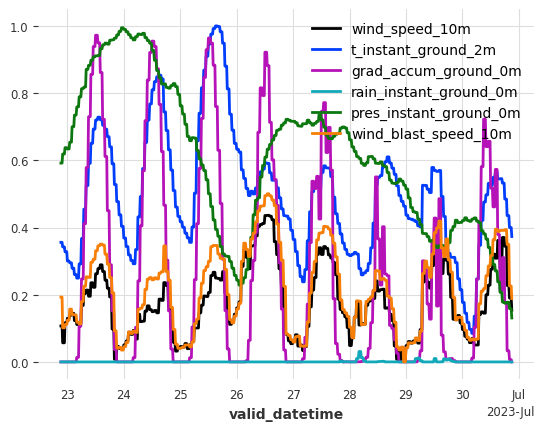

In [115]:
val_weather.plot()

In [119]:
backtest = regr_model.historical_forecasts(
    meter_ts,
    past_covariates=weather_ts,
    start=val_meter.start_time(),
    forecast_horizon=96,
    stride=96,
    last_points_only=False,
    retrain=False,
    verbose=True,
)

  0%|          | 0/1 [00:00<?, ?it/s]

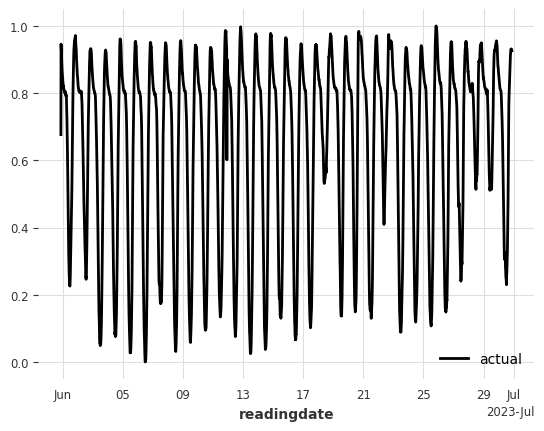

In [123]:
import matplotlib.pyplot as plt

meter_ts.plot(label='actual')
# backtest.plot(label='backcasted')

plt.show()


MAPE = 35.31%
SMAPE = 38.47%
MAE = 0.22%


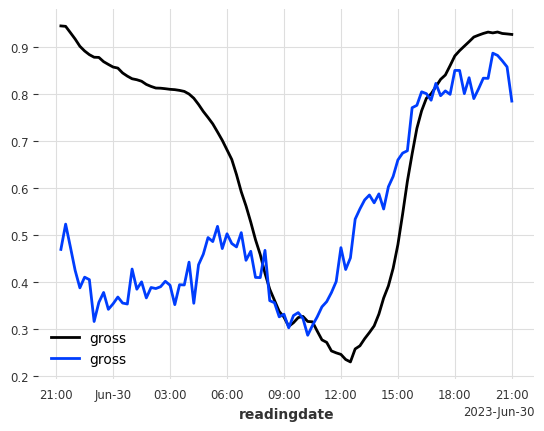

In [116]:
from darts.metrics import mape, smape, mae

# regr_model.predict(1)
# eval_model(regr_model, val_weather)

# plot acutals against the predicted horizon
val_meter[-96:].plot()
pred = regr_model.predict(96, val_meter[:-96], val_weather[:-96])
pred.plot()

print("MAPE = {:.2f}%".format(mape(val_meter[-96:], pred)))
print("SMAPE = {:.2f}%".format(smape(val_meter[-96:], pred)))
print("MAE = {:.2f}%".format(mae(val_meter[-96:], pred)))


In [21]:
from darts.metrics import rmse

# We first set aside the first 80% as training series:

def eval_model(model, past_covariates=None, future_covariates=None):
    # Past and future covariates are optional because they won't always be used in our tests
    
    # We backtest the model on the last 20% of the flow series, with a horizon of 10 steps:
    backtest = model.historical_forecasts(series=meter_ts, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=0.8, 
                                          retrain=False,
                                          verbose=True, 
                                          forecast_horizon=1)
    
    meter_ts[-len(backtest)-100:].plot()
    backtest.plot(label='backtest (n=10)')
    print('Backtest RMSE = {}'.format(rmse(meter_ts, backtest)))

### Custom Loss

In [46]:
import torch
import torch.nn as nn

# Define your custom loss function
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        # Define your loss components here

    def forward(self, output, target):
        # Calculate your custom loss
        loss = torch.mean((output - target)**2)  # Example custom loss (MSE)
        return loss

In [47]:
torch_kwargs = {
    'loss_fn': CustomLoss()
}

## LSTM with Darts

In [48]:
from darts.models import (
    NBEATSModel,
    BlockRNNModel
)

from darts.utils.timeseries_generation import datetime_attribute_timeseries


model_name = "BlockRNN_test"
model_lstm = BlockRNNModel(
    model="LSTM",
    input_chunk_length=24,
    output_chunk_length=4,
    n_epochs=10,
    random_state=0,
    model_name=model_name,
    save_checkpoints=True,  # store model states: latest and best performing of validation set
    force_reset=True,
    **torch_kwargs
    # **generate_torch_kwargs()
)

<Axes: xlabel='valid_datetime'>

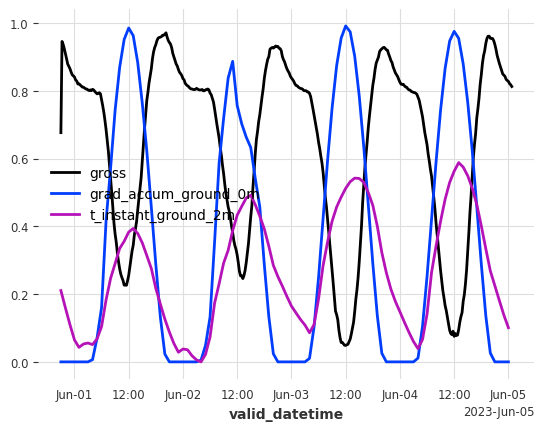

In [65]:
meter_ts[0:400].plot()
weather_ts[0:100][['grad_accum_ground_0m', 't_instant_ground_2m']].plot()

In [36]:
train, val = meter_ts.split_after(0.8)

In [49]:
model_lstm.fit(
    train,
    past_covariates=weather_ts,
    # future_covariates=actuals_ts
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | CustomLoss       | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 3.4 K 
4 | fc            | Sequential       | 104   
---------------------------------------------------
3.5 K     Trainable params
0         Non-trainable params
3.5 K     Total params
0.014     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


BlockRNNModel(output_chunk_shift=0, model=LSTM, hidden_dim=25, n_rnn_layers=1, hidden_fc_sizes=None, dropout=0.0, input_chunk_length=24, output_chunk_length=4, n_epochs=10, random_state=0, model_name=BlockRNN_test, save_checkpoints=True, force_reset=True, loss_fn=CustomLoss())

## TFTModel



In [ ]:
pl.Config.set_float_precision(3)
# df_for_train = df_for_train.sort(['ean_sha256', 'readingdate'])
pipeline = (
    non_pv.lazy()
    .with_columns(
        (pl.col('ldn') - pl.col('ldn').shift(1)).over('ean_sha256').alias('ldn_diff'),
        (pl.col('odn') - pl.col('odn').shift(1)).over('ean_sha256').alias('odn_diff')
    ).with_columns(
        (pl.col('ldn_diff') - pl.col('odn_diff')).alias('gross')
    )
)

non_pv = pipeline.collect()
non_pv = non_pv.select(pl.col('readingdate'), pl.col('gross'))
non_pv = non_pv.group_by('readingdate').agg(pl.sum('gross')).sort('readingdate')
non_pv

In [ ]:
pl.Config.set_float_precision(3)
# df_for_train = df_for_train.sort(['ean_sha256', 'readingdate'])
pipeline = (
    pv.lazy()
    .with_columns(
        (pl.col('ldn') - pl.col('ldn').shift(1)).over('ean_sha256').alias('ldn_diff'),
        (pl.col('odn') - pl.col('odn').shift(1)).over('ean_sha256').alias('odn_diff')
    ).with_columns(
        (pl.col('ldn_diff') - pl.col('odn_diff')).alias('gross')
    )
)

pv = pipeline.collect()

pv = pv.select(pl.col('readingdate'), pl.col('gross'))
pv = pv.group_by('readingdate').agg(pl.sum('gross')).sort('readingdate')
pv_df = pv.to_pandas()
pv_df['readingdate'] = pd.to_datetime(pv_df['readingdate'])
pv_df = pv_df.set_index('readingdate')
pv_df

In [52]:
from darts.models import TFTModel
from darts import TimeSeries


input_chunk_length = 7 * 24 #* 4
forecast_horizon = 1 * 24 #* 4
# use `add_encoders` as we don't have future covariates
# from Paper
# model = TFTModel(
#     input_chunk_length=input_chunk_length, # encoder_length
#     output_chunk_length=forecast_horizon,
#     num_attention_heads=2,
#     hidden_size=60,
#     hidden_continuous_size=30,
#     lstm_layers=2,
#     batch_size=1024,
#     n_epochs=5,
#     dropout=0.7,
#     # add_encoders={"cyclic": {"future": ["month"]}},
#     add_relative_index=False,
#     optimizer_kwargs={"lr": 0.001}, # learning rate
#     use_static_covariates=False,
#     random_state=42,
# )

model= TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=32,
    lstm_layers=1,
    batch_size=16,
    n_epochs=5,
    dropout=0.1,
    add_encoders={"cyclic": {"future": ["month"]}},
    add_relative_index=False,
    optimizer_kwargs={"lr": 1e-3},
    random_state=42,
    **torch_kwargs
)

### Min Max Scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()

In [ ]:
pv_df[['gross']] = scaler.fit_transform(pv_df[['gross']])
pv_df

### Training

In [54]:
weather_ts.time_index

DatetimeIndex(['2023-04-01 00:00:00', '2023-04-01 00:15:00',
               '2023-04-01 00:30:00', '2023-04-01 00:45:00',
               '2023-04-01 01:00:00', '2023-04-01 01:15:00',
               '2023-04-01 01:30:00', '2023-04-01 01:45:00',
               '2023-04-01 02:00:00', '2023-04-01 02:15:00',
               ...
               '2023-07-31 20:45:00', '2023-07-31 21:00:00',
               '2023-07-31 21:15:00', '2023-07-31 21:30:00',
               '2023-07-31 21:45:00', '2023-07-31 22:00:00',
               '2023-07-31 22:15:00', '2023-07-31 22:30:00',
               '2023-07-31 22:45:00', '2023-07-31 23:00:00'],
              dtype='datetime64[ns]', name='valid_datetime', length=11709, freq='15min')

In [57]:
dummy_covariate = pd.Series(0, index=train.time_index)  # Adjust the constant value as needed

# fit the model with past covariates
model.fit(
    train, 
    past_covariates=weather_ts, 
    future_covariates=actuals_ts, 
    verbose=True
)

ValueError: Missing covariates; could not find past covariates in index value range: 2023-06-22 21:45:00 - 2023-06-24 15:30:00.


ValueError: Missing covariates; could not find past covariates in index value range: 2023-06-22 21:45:00 - 2023-06-24 15:30:00.

### Evaluating

In [ ]:
from darts.metrics import rmse

# We first set aside the first 80% as training series:
flow_train, _ = flow.split_before(0.8)

def eval_model(model, past_covariates=None, future_covariates=None):
    # Past and future covariates are optional because they won't always be used in our tests
    
    # We backtest the model on the last 20% of the flow series, with a horizon of 10 steps:
    backtest = model.historical_forecasts(series=flow, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=0.8, 
                                          retrain=False,
                                          verbose=True, 
                                          forecast_horizon=10)
    
    flow[-len(backtest)-100:].plot()
    backtest.plot(label='backtest (n=10)')
    print('Backtest RMSE = {}'.format(rmse(flow, backtest)))